In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import read_csv
sns.set_theme(style='white', context='notebook', font_scale=1.33)

## Load parameters

In [2]:
weights = np.array([-1, 0, 1])
stan_model = '3pl_m2'

## Load StanFit.
f = os.path.join('stan_results', f'{stan_model}_summary.tsv')
params = read_csv(f, sep='\t', index_col=0)

def inv_logit(x):
    return 1 / (1 + np.exp(-x))

## Extract parameters.
beta  = params.T.filter(regex='beta\[').T['Mean'].values
alpha = params.T.filter(regex='alpha\[').T['Mean'].values
gamma = 0.25


mu = np.outer(weights, alpha) - beta
p = gamma + (1-gamma) * inv_logit(mu)
q = 1 - p

W = np.square(alpha) * (q / p) * np.square((p - gamma) / (1 - gamma))
W = W.T

### Assembly 1

This is an example to construct a single test.

In [3]:
from mip import Model, xsum, maximize, BINARY

## Define metadata.
n_item = len(beta)
n_test = 12

## Initialize model.
model = Model("assembly")

## Initialize binary variables.
x = [model.add_var(var_type=BINARY) for i in range(n_item)]

## Define objective.
model.objective = maximize(xsum(x[i] * W[i].sum() for i in range(n_item)))

## Constraint #1: maximum number of items.
model += xsum(x[i] for i in range(n_item)) <= n_test

## Constraint #2: one item per family.
for i in range(0,n_item,6): 
    model += xsum(x[i:i+6]) <= 1
    
## Optimize.
model.optimize(max_seconds=120)

selected = np.array([i for i in range(n_item) if x[i].x >= 0.99])
print(selected)

[ 51  77  93 124 129 147 191 237 243 303 329 358]


### Assembly 2a

[ 51  75  93 123 126 129 147 189 243 303 327 357]


(0.0, 4.0)

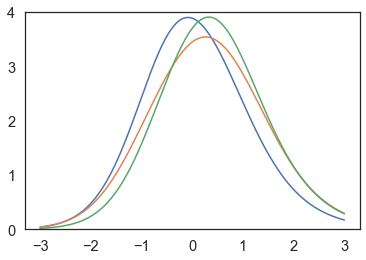

In [4]:
from mip import Model, xsum, maximize, BINARY

## Define metadata.
n_item = len(beta)
n_test = 12

## Initialize model.
model = Model("assembly")

## Initialize binary variables.
x = [model.add_var(var_type=BINARY) for i in range(n_item // 3)]

## Define objective.
model.objective = maximize(xsum(x[i] * W[i*3:(i+1)*3].sum() for i in range(n_item//3)))

## Constraint #1: maximum number of items.
model += xsum(x[i] for i in range(n_item//3)) <= n_test

## Optimize.
model.optimize(max_seconds=120)

selected = np.array([i*3 for i in range(n_item//3) if x[i].x])
print(selected)

for i in range(3):
    theta = np.linspace(-3,3,1001)
    mu = np.outer(theta,alpha[selected+i]) - beta[selected+i]
    p = gamma + (1-gamma) * inv_logit(mu)
    q = 1 - p
    I = np.square(alpha[selected]) * (q / p) * np.square((p - gamma) / (1 - gamma))
    plt.plot(theta, I.sum(axis=1))
plt.ylim(0,4)

### Assembly 2b

[ 51 120 123 126 129 147 189 243 297 303 327 357]


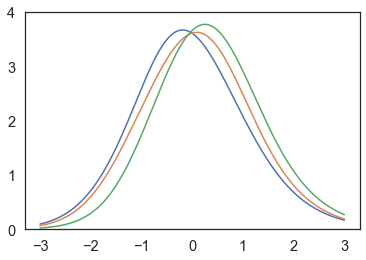

In [5]:
from mip import Model, xsum, maximize, BINARY

## Define metadata.
n_item = len(beta)
n_test = 12
tol = 5e-2

## Initialize model.
model = Model("assembly")

## Initialize binary variables.
x = [model.add_var(var_type=BINARY) for i in range(n_item // 3)]

## Define objective.
model.objective = maximize(xsum(x[i] * W[i*3:(i+1)*3].sum() for i in range(n_item//3)))

## Constraint #1: maximum number of items.
model += xsum(x[i] for i in range(n_item//3)) <= n_test

## Constraint #2: minimize differences.
model += xsum(x[i] * W[i*3+0].sum() for i in range(n_item//3)) -\
         xsum(x[i] * W[i*3+1].sum() for i in range(n_item//3)) <= tol
model += xsum(x[i] * W[i*3+1].sum() for i in range(n_item//3)) -\
         xsum(x[i] * W[i*3+0].sum() for i in range(n_item//3)) <= tol
model += xsum(x[i] * W[i*3+0].sum() for i in range(n_item//3)) -\
         xsum(x[i] * W[i*3+2].sum() for i in range(n_item//3)) <= tol
model += xsum(x[i] * W[i*3+2].sum() for i in range(n_item//3)) -\
         xsum(x[i] * W[i*3+0].sum() for i in range(n_item//3)) <= tol

## Optimize.
model.optimize(max_seconds=120)

selected = np.array([i*3 for i in range(n_item//3) if x[i].x])
print(selected)

for i in range(3):
    theta = np.linspace(-3,3,1001)
    mu = np.outer(theta,alpha[selected+i]) - beta[selected+i]
    p = gamma + (1-gamma) * inv_logit(mu)
    q = 1 - p
    I = np.square(alpha[selected]) * (q / p) * np.square((p - gamma) / (1 - gamma))
    plt.plot(theta, I.sum(axis=1))
plt.ylim(0,4);

### Assembly 3

[ 16  28  40  51  65  71  77  95 112 124 130 147 153 177 191 215 226 232
 237 243 253 262 287 291 299 303 311 312 329 333 339 345 353 358 371 377]


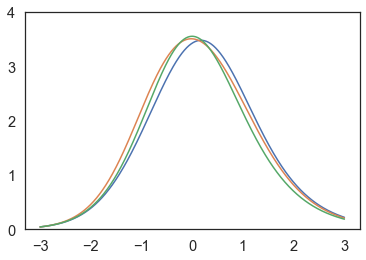

In [6]:
from mip import Model, xsum, maximize, BINARY

## Define metadata.
n_item = len(beta)
n_test = 36
tol = 1

## Initialize binary variables.
x = [model.add_var(var_type=BINARY) for i in range(n_item)]

## Define objective.
model.objective = maximize(xsum(x[i] * W[i].sum() for i in range(n_item)))

## Constraint #1: maximum number of items.
model += xsum(x[i] for i in range(n_item)) <= n_test

## Constraint #2: one item per family.
for i in range(0,n_item,6): 
    model += xsum(x[i:i+6]) <= 1
    
## Constraint #3: minimize differences.
model += xsum(x[i] * W[i].sum() for i in range(0,n_item,3)) -\
         xsum(x[i] * W[i].sum() for i in range(1,n_item,3)) <= tol
model += xsum(x[i] * W[i].sum() for i in range(1,n_item,3)) -\
         xsum(x[i] * W[i].sum() for i in range(0,n_item,3)) <= tol
model += xsum(x[i] * W[i].sum() for i in range(0,n_item,3)) -\
         xsum(x[i] * W[i].sum() for i in range(2,n_item,3)) <= tol
model += xsum(x[i] * W[i].sum() for i in range(2,n_item,3)) -\
         xsum(x[i] * W[i].sum() for i in range(0,n_item,3)) <= tol
    
## Optimize.
model.optimize(max_seconds=120)

selected = np.array([i for i in range(n_item) if x[i].x])
print(selected)

for i in range(3):
    theta = np.linspace(-3,3,1001)
    mu = np.outer(theta,alpha[selected[i::3]]) - beta[selected[i::3]]
    p = gamma + (1-gamma) * inv_logit(mu)
    q = 1 - p
    I = np.square(alpha[selected[i::3]]) * (q / p) * np.square((p - gamma) / (1 - gamma))
    plt.plot(theta, I.sum(axis=1))
plt.ylim(0,4);

### Assembly 4a

[ 53  75  95 125 131 149 191 244 291 303 329 358]


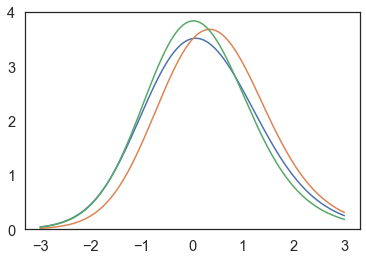

In [7]:
## Define indices.
triples = []
for i in range(0, n_item, 3):
    triple = list(range(i,i+3))
    for j in range(3): triples.append(np.roll(triple, j).tolist())
    
## Define metadata.
n_item = len(triples)
n_test = 12

## Initialize model.
model = Model("assembly")

## Initialize binary variables.
x = [model.add_var(var_type=BINARY) for i in range(n_item)]

## Define objective.
model.objective = maximize(xsum(x[i] * W[ix].sum() for i, ix in enumerate(triples)))

## Constraint #1: maximum number of triples.
model += xsum(x[i] for i in range(n_item)) <= n_test

## Constraint #2: one set per family.
for i in range(0,n_item,6): 
    model += xsum(x[i:i+6]) <= 1

## Optimize.
model.optimize(max_seconds=120)

selected = np.array([i for i in range(n_item) if x[i].x])
print(selected)

for i in range(3):
    ix = [triples[j][i] for j in selected]
    theta = np.linspace(-3,3,1001)
    mu = np.outer(theta, alpha[ix]) - beta[ix]
    p = gamma + (1-gamma) * inv_logit(mu)
    q = 1 - p
    I = np.square(alpha[ix]) * (q / p) * np.square((p - gamma) / (1 - gamma))
    plt.plot(theta, I.sum(axis=1))
plt.ylim(0,4);

### Assembly 4b

[ 52  77  93 125 129 147 191 245 292 305 327 357]


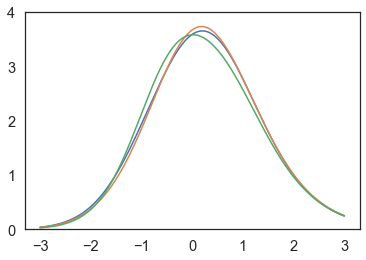

In [8]:
## Define indices.
triples = []
for i in range(0, n_item, 3):
    triple = list(range(i,i+3))
    for j in range(3): triples.append(np.roll(triple, j).tolist())
    
## Define metadata.
n_item = len(triples)
n_test = 12
tol = 1e-2

## Initialize model.
model = Model("assembly")

## Initialize binary variables.
x = [model.add_var(var_type=BINARY) for i in range(n_item)]

## Define objective.
model.objective = maximize(xsum(x[i] * W[ix].sum() for i, ix in enumerate(triples)))

## Constraint #1: maximum number of triples.
model += xsum(x[i] for i in range(n_item)) <= n_test

## Constraint #2: one set per family.
for i in range(0,n_item,6): 
    model += xsum(x[i:i+6]) <= 1

## Constraint #3: minimize differences.
model += xsum(x[i] * W[j1].sum() for i, (j1,j2,j3) in enumerate(triples)) -\
         xsum(x[i] * W[j2].sum() for i, (j1,j2,j3) in enumerate(triples)) <= tol
model += xsum(x[i] * W[j2].sum() for i, (j1,j2,j3) in enumerate(triples)) -\
         xsum(x[i] * W[j1].sum() for i, (j1,j2,j3) in enumerate(triples)) <= tol
model += xsum(x[i] * W[j1].sum() for i, (j1,j2,j3) in enumerate(triples)) -\
         xsum(x[i] * W[j3].sum() for i, (j1,j2,j3) in enumerate(triples)) <= tol
model += xsum(x[i] * W[j3].sum() for i, (j1,j2,j3) in enumerate(triples)) -\
         xsum(x[i] * W[j1].sum() for i, (j1,j2,j3) in enumerate(triples)) <= tol
    
## Optimize.
model.optimize(max_seconds=120)

selected = np.array([i for i in range(n_item) if x[i].x])
print(selected)

for i in range(3):
    ix = [triples[j][i] for j in selected]
    theta = np.linspace(-3,3,1001)
    mu = np.outer(theta, alpha[ix]) - beta[ix]
    p = gamma + (1-gamma) * inv_logit(mu)
    q = 1 - p
    I = np.square(alpha[ix]) * (q / p) * np.square((p - gamma) / (1 - gamma))
    plt.plot(theta, I.sum(axis=1))
plt.ylim(0,4);

In [9]:
for i in range(3):
    print([triples[j][i] for j in selected])

[53, 76, 93, 124, 129, 147, 190, 244, 293, 304, 327, 357]
[51, 77, 94, 125, 130, 148, 191, 245, 291, 305, 328, 358]
[52, 75, 95, 123, 131, 149, 189, 243, 292, 303, 329, 359]


array([ 53,  51,  52,  76,  77,  75,  93,  94,  95, 124, 125, 123, 129,
       130, 131, 147, 148, 149, 190, 191, 189, 244, 245, 243, 293, 291,
       292, 304, 305, 303, 327, 328, 329, 357, 358, 359])

<AxesSubplot:>

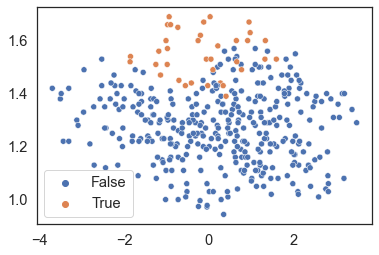

In [18]:
sns.scatterplot(
    x=beta,
    y=alpha,
    hue =np.in1d(np.arange(n_item), np.concatenate([triples[i] for i in selected]))
)

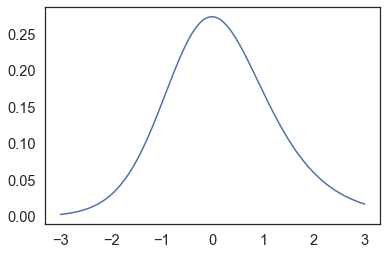

In [24]:
theta = np.linspace(-3,3,1001)

beta = -0.33
alpha = 1.5

for alpha in [ 1.33]:

    p = gamma + (1-gamma) * inv_logit(alpha * theta - beta)
    q = 1-p
    I = alpha**2 * (q/p) * np.square((p - gamma) / (1 - gamma))

    plt.plot(theta, I)

In [15]:
np.concatenate([triples[i] for i in selected])

array([ 53,  51,  52,  76,  77,  75,  93,  94,  95, 124, 125, 123, 129,
       130, 131, 147, 148, 149, 190, 191, 189, 244, 245, 243, 293, 291,
       292, 304, 305, 303, 327, 328, 329, 357, 358, 359])